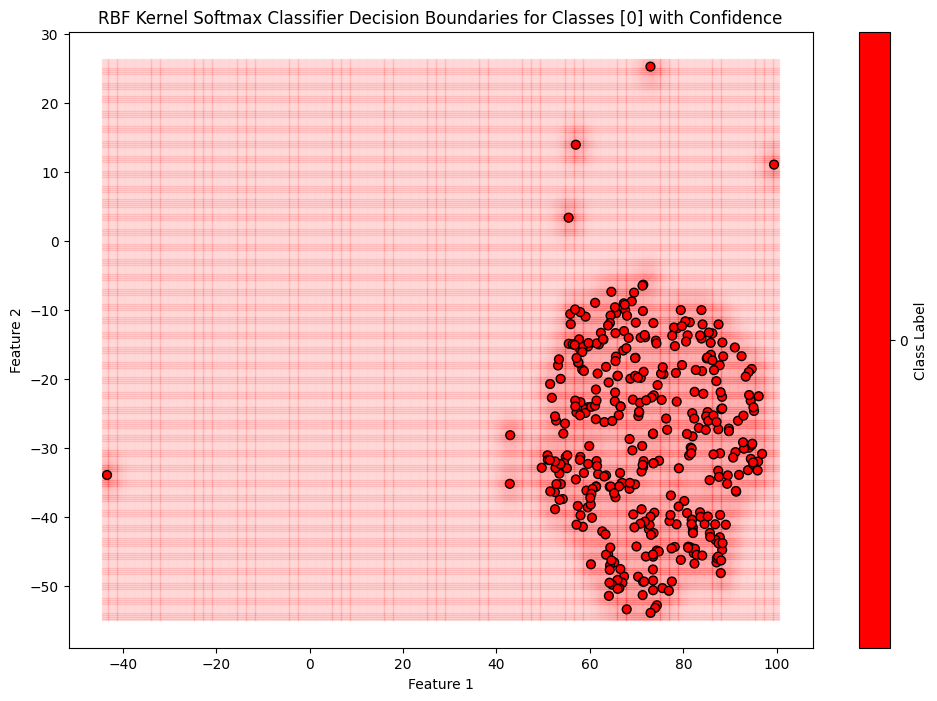

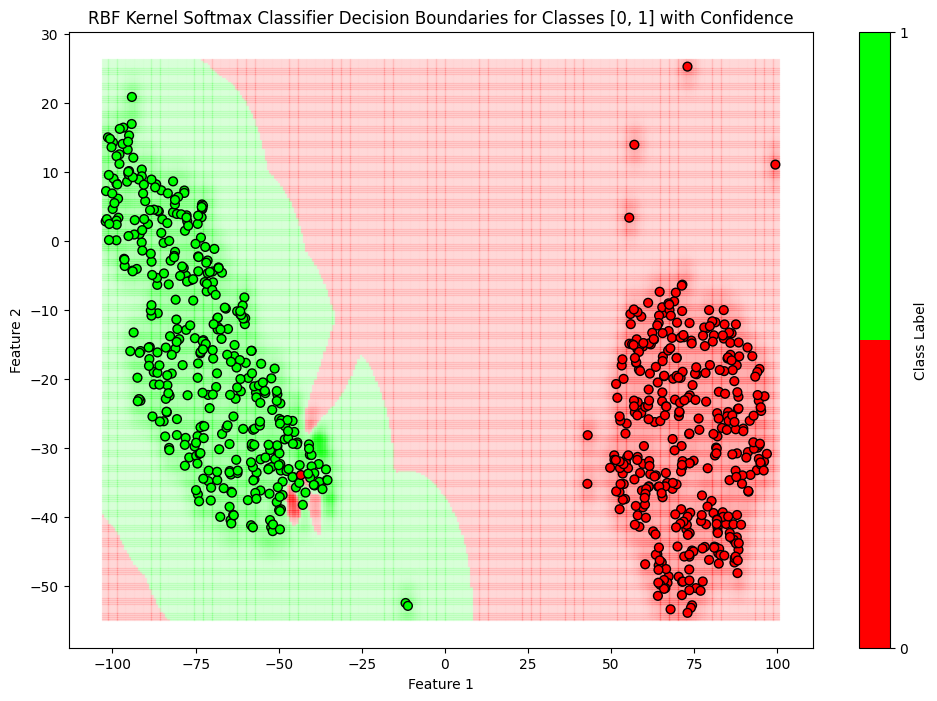

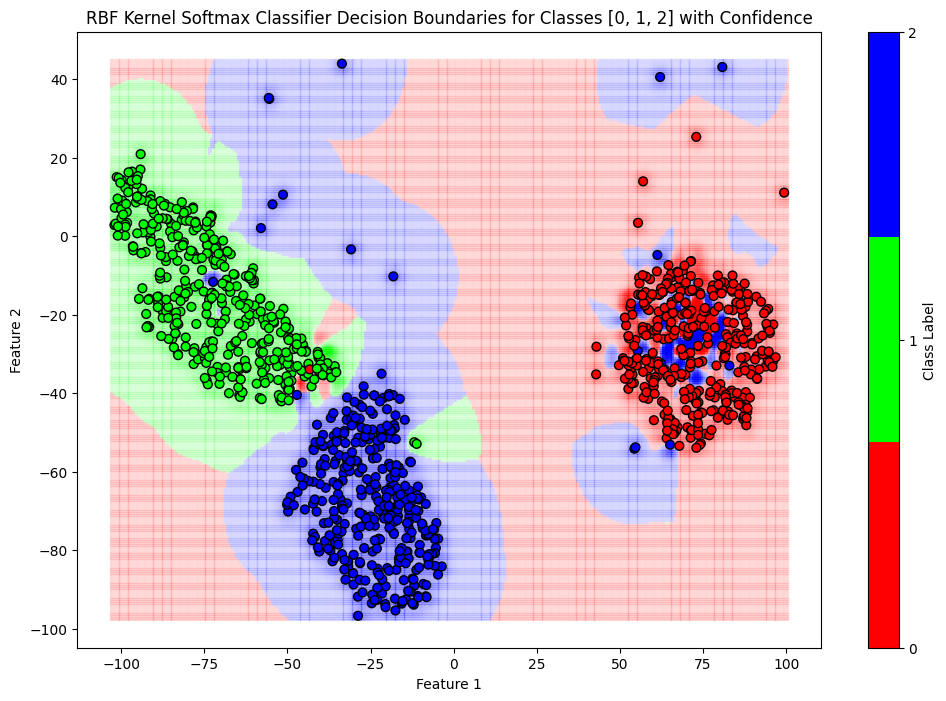

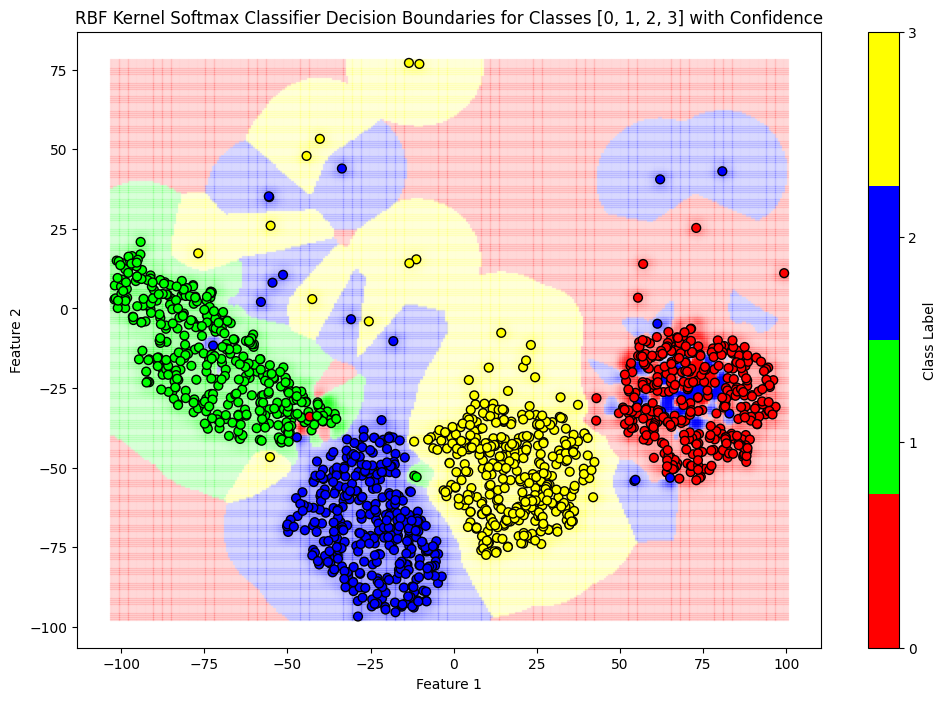

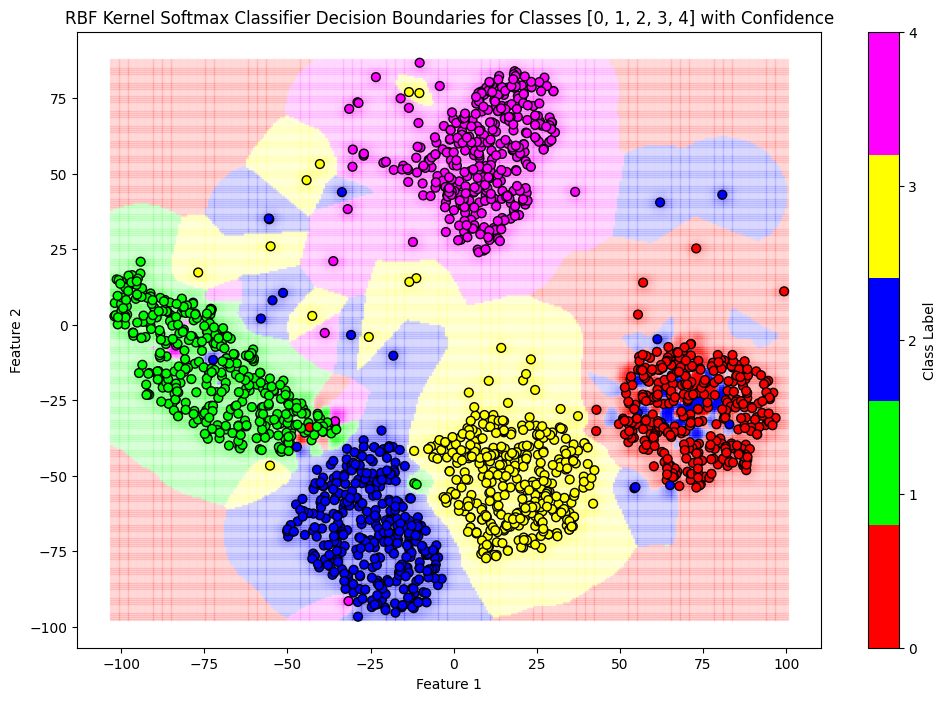

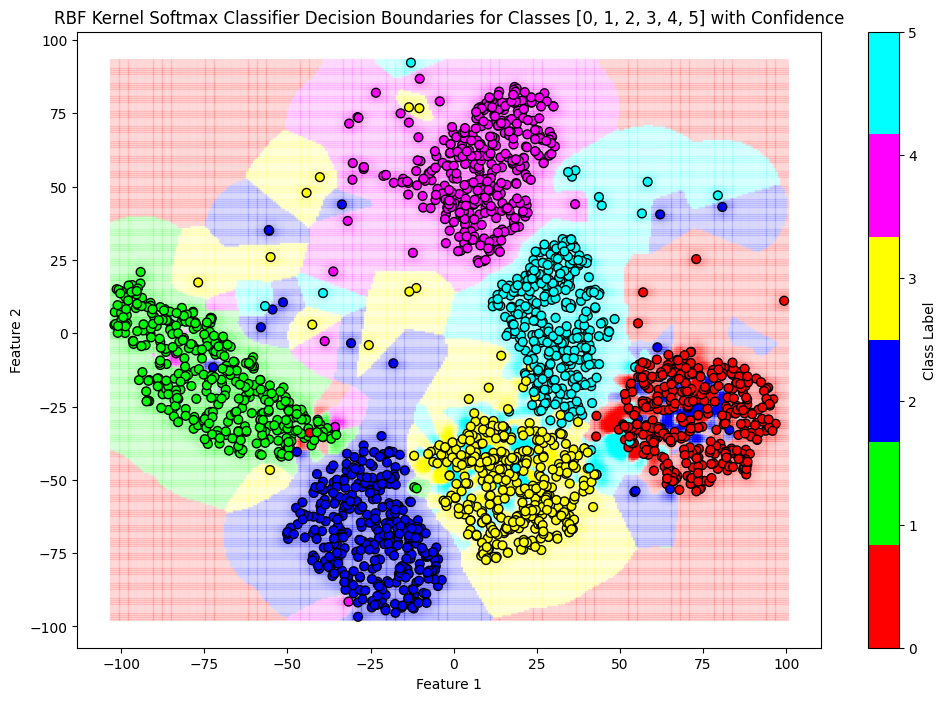

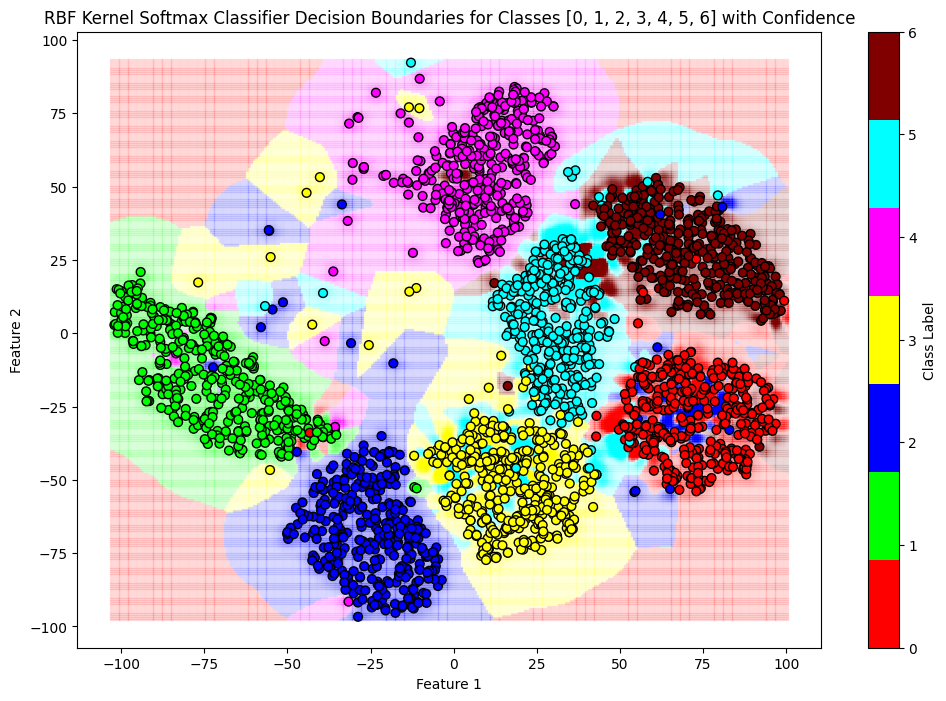

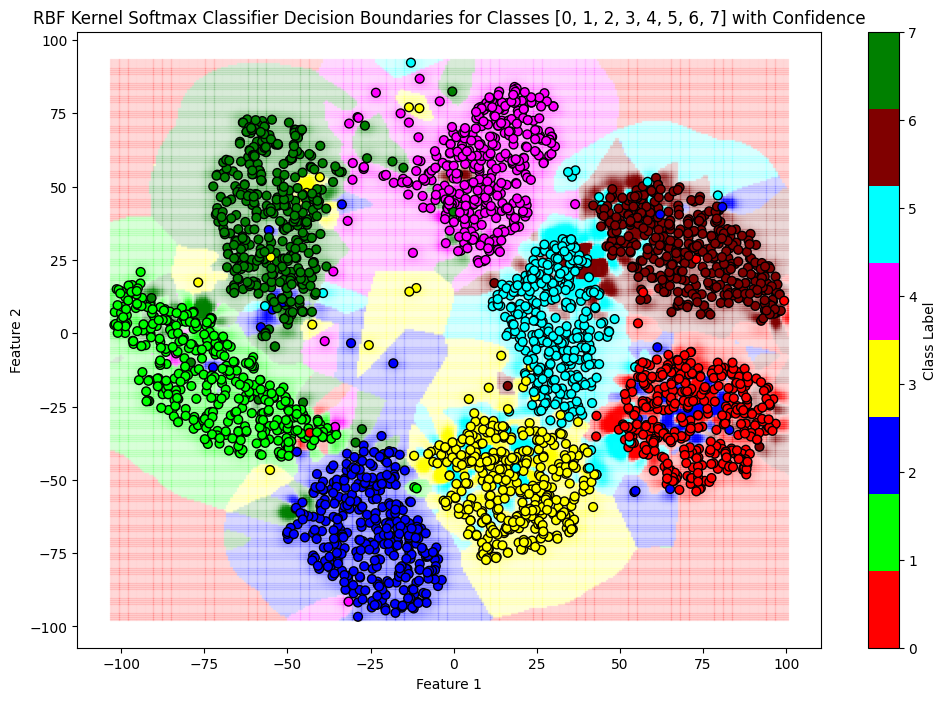

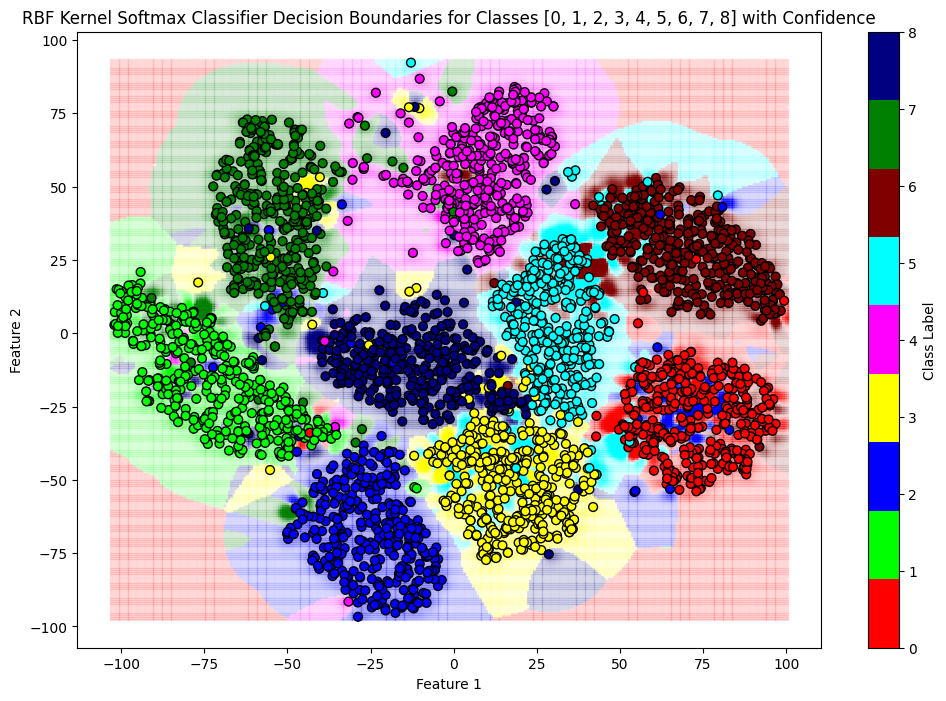

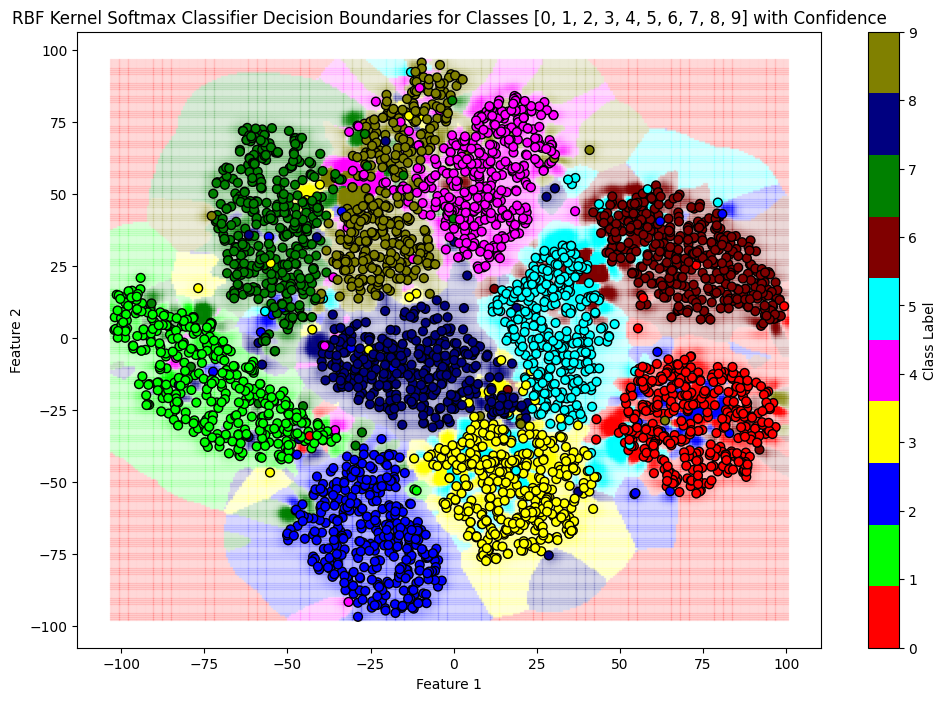

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap

class RBFKernelSoftmaxClassifier:
    def __init__(self, gamma=1.0):
        self.gamma = gamma
        self.weights = None
        self.X_train = None

    def rbf_kernel(self, X1, X2):
        # RBF kernel function
        pairwise_sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * pairwise_sq_dists)

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # Subtract max for numerical stability
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def fit(self, X, y_one_hot):
        self.X_train = X
        K = self.rbf_kernel(X, X)  # Compute the kernel matrix
        self.weights = np.linalg.pinv(K).dot(y_one_hot)  # Solve the linear system

    def predict_proba(self, X):
        K = self.rbf_kernel(X, self.X_train)  # Compute kernel values between test and training data
        logits = K.dot(self.weights)  # Compute logits
        return self.softmax(logits)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Random Seed for Reproducibility
np.random.seed(42)

# TODO : Load the dataset
X = np.load('features_q2.npy')
y_one_hot = np.load('labels_q2.npy')
y = np.argmax(y_one_hot, axis=1)

def plot_decision_boundaries(X, y, classifier, classes_to_keep, grid, predicted_classes, confidence):
    # Set up the color map for the current classes
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
              '#800000', '#008000', '#000080', '#808000']
    colormap = ListedColormap(colors[:len(classes_to_keep)])

    # Normalize the confidence to [0, 1] for color brightness
    norm = Normalize(vmin=0, vmax=1.0)

    # Create the plot
    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(classes_to_keep):
        # Extract mask for the i-th class
        mask = predicted_classes == cls

        # Enhance contrast by squaring the normalized confidence values
        enhanced_alpha = norm(confidence[mask])

        # Plot regions with varying brightness based on confidence
        plt.scatter(grid[mask, 0], grid[mask, 1], color=colormap(i),
                    alpha=enhanced_alpha, marker='s', s=1)

    # Plot the data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colormap, edgecolor='k', s=40)
    plt.colorbar(scatter, ticks=classes_to_keep, label="Class Label")
    plt.title(f'RBF Kernel Softmax Classifier Decision Boundaries for Classes {classes_to_keep} with Confidence')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Loop through different subsets of classes
for num_classes in range(1, 11):
    classes_to_keep = list(range(num_classes))

    # Filter data for the current classes
    filtered_indices = np.where(np.isin(y, classes_to_keep))[0]
    X_filtered = X[filtered_indices]
    y_filtered = y[filtered_indices]
    y_one_hot_filtered = y_one_hot[filtered_indices]

    # Instantiate and train the RBF kernel classifier
    classifier = RBFKernelSoftmaxClassifier(gamma=0.1)
    classifier.fit(X_filtered, y_one_hot_filtered)

    # Set up meshgrid for visualization
    x_min, x_max = X_filtered[:, 0].min() - 1, X_filtered[:, 0].max() + 1
    y_min, y_max = X_filtered[:, 1].min() - 1, X_filtered[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict probabilities across the grid
    proba = classifier.predict_proba(grid)

    # Calculate the class with the highest probability and the confidence
    predicted_classes = np.argmax(proba, axis=1)
    confidence = np.max(proba, axis=1)
    if num_classes == 10:
      final_results = {
          'X' : [],
          'y' : [],
          'conf' : []
      }
      final_results['X'] = list(map(tuple, grid))
      final_results['y'] = predicted_classes
      final_results['conf'] = confidence
      import pandas as pd
      df = pd.DataFrame(final_results)
      df.to_csv('output.csv')
    # Visualize the decision boundaries
    plot_decision_boundaries(X_filtered, y_filtered, classifier, classes_to_keep, grid, predicted_classes, confidence)
